
# Topic Modeling of CORD-19 Dataset

## Introduction

In this project, we will try to investigate various methods of topic modeling using sparse matrix factorization.   

Topic modeling is a common task in natural language processing (NLP), in which we try and model the range of topics in a particular corpus, as well as represent each document as a distribution of topics \cite{jelodar2019latent}. There are a variety of methods by which this is done. The most famous of which is Latent Dirichelt Allocation, a generative probablistic model \cite{blei2003latent}. In this method, we consider a generative process by which we create a document based off of some latent topics. These topics have word distributions. When we create a document, we use a  Dirichlet distribution to first select a topic, then a word from that topic's distribution. Given this generative process, given a corpus, we can use various statistical inference methods to determine the underlying latent topic distributions.    

## Matrix Factorization

However, we can also use Nonnegative Matrix factorization to model this problem \cite{lee1999learning}. In this case, we take a sparse matrix, such as a document-term matrix and attempt to approximate a low-rank approximation of the form 

$$
\mathbf{X} \approx \mathbf{W}\mathbf{H}
$$

where

$$
\mathbf{X} \epsilon \mathbb{R}^{p \times n}, \mathbf{W} \epsilon \mathbb{R}^{p \times r}, \mathbf{H} \epsilon \mathbb{R}^{r \times n}
$$

and hopefully $r << p$. In our case, this would mean that we'd end up with a word-topic matrix and a topic-document matrix. We can then use these independent documents to either generate new documents of various topic distributions or quantify the topic distribution of a new document! Exciting stuff!   

## Hierarchical Poisson Factorization (HPF)

In addition to NMF, we'll also be implementing a more novel approach, known as hierarchical Poisson factorization (HPF) \cite{gopalan2015scalable}. HPF was developed as an improvement to the recently popularized (by the Netflix Prize) recommendation problem. The algorithm has its roots in NMF, but makes some significant modifications. In the recommendation setting of the problem, HPF takes in a user behavior matrix, which is a matrix of users as rows, and items that have been consumed as columns. For recommendation, we have a binary matrix (1 = consumed, 0 = not consumed), however, we can use continuous ratings instead.     


The data are modeled as factorized Poisson distributions, where each user has *K* latent preferences and each item has *K* latent attributes. The observations (entries in matrix) are modeled as a Poisson distribution, parameterized by the inner product of the corresponding user and item latent value vectors. Given this matrix, the basic generative model is as follows:

1. For each user *u*:
    1. For each latent variable *k*: 
        - sample preference $\theta_{uk} \sim Gamma$
2. For each item *i*:
    1.  For each latent variable *k*:
        - sample attribute $\beta_{ik} \sim Gamma$
3. For each *u* and *i*, sample rating/consumption:
    - $y_{ui} \sim Poisson$
    
Each of the Gamma distributions above are also further parameterized by Gamma distributions. For simplicity, we've removed the parameters above, but the plate notation diagram is as below: 

<img src="./hpf_plate_notation.png" alt="HPF_Plate_Notation"
	title="HPF Plate Notation" width="400" />
    
There are a number of similarities between our text corpus and the user behavior matrix

    
| HPF Attribute                                | User Behavior                                                                                                                                 | Corpus Topic Modeling                                                                                                                                                                                          |
|----------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Additional Priors on  latent variable Gammas | Captures the diversity of users,  some tending to consume more than others,  and the diversity of items,  some being more popular than others | Some documents contain many topics while  some are about a singular topic.  Some topics are more prevalence than others.                                                                                       |
| Estimation of Posterior Expectation          | Each user’s preferences and each items attributes                                                                                             | Each document's topics and  each word's semantics                                                                                                                                                              |
| Model of Long-Tailed Behavior                | While most users consume a handful few items,  a few “tail users” consume thousands of items                                                  | While most documents only consist of a few topics,  some documents may be review articles that have to do with  many topics                                                                                    |
| Downweights effects of 0s                    | A user that consumes an item  must be interested in it so 1s are more relevant than 0s                                                        | There are lots of words that are completely unrelated to  a document, while a few are very relevant (within the corresponding  topic). We should focus on these occurrences rather than the lack of most words |

In the last example, normal randomized MF uses Gaussian likelihoods which weight seen and unseen examples equally, which in a sparse matrix, means most factors relie on the "unconsumed" user/item pairs. HPF corrects for this problem. 

---

Now that we've provided some background and (hopefully) effectively motivated the use of HPF in Topic Modeling, let's get started!

In [1]:
from gensim.test.utils import datapath
import warnings 
warnings.filterwarnings("ignore")

We will be using the CORD-19 dataset from Semantic Scholar. The dataset consists of several thousand articles related to COVID-19 published in peer-reviewed publications and archival services like bioRxiv, medRxiv, and others. Some work in the topic modeling space has already been done using this dataset, with the goal of identifying novel research gaps, but we'll see how well HPF works \cite{doanvo2020machine}. 

In [2]:
data_path = "/home/vs428/scratch60/cord19/2020-12-10/metadata.csv"

## Create a Text Corpus

First, we'll create a dictionary from the titles and abstracts of all the CORD-19 articles by reading in the `metadata.csv` file. We originally had planned to stream over the full text paper directory but decided against it, due to size and runtime constraints. 

In [3]:
import csv
from gensim.parsing.preprocessing import *
from gensim.corpora import Dictionary
import gensim

### Read in Data

In [4]:
subset_num = 20000

In [5]:
cord_text = []
CUSTOM_FILTERS = [
strip_tags,
strip_punctuation,
strip_multiple_whitespaces,
strip_numeric,
remove_stopwords,
lambda x: strip_short(x, minsize=2)]
i = 0
with open(data_path, "r+") as csvfile:
    reader = csv.reader(csvfile)
    header = next(reader)
    # title is idx 3
    # abstract is idx 8
    print(header)
    for row in reader:
        row_text = preprocess_string((row[3] + ". " + row[8]).lower(), CUSTOM_FILTERS)
        cord_text.append(row_text)
        i += 1
        if i % subset_num == 0:
            break          

['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id', 'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files', 'url', 's2_id']


### Create a Dictionary

In [6]:
dictionary = Dictionary(cord_text)

In [7]:
print(f"Total Number of docs: {dictionary.num_docs}")
print(f"Total Number of tokens: {dictionary.num_pos}")
print(f"Total Unique tokens: {len(dictionary.token2id)}")

Total Number of docs: 20000
Total Number of tokens: 1858840
Total Unique tokens: 79738


Originally, we were going to use the full text of the articles, but decided to lessen our scope to only include titles and abstracts. Previous NLP studies often take this approach, as we know that the majority of the important text information of the article, including hypotheses, methods, and conclusions are often found in the title and abstract. 

The code to stream over the data is kept below as an example however. 

In [8]:
# cord_text = []
# dictionary = Dictionary()

# with open(data_path, "r+") as csvfile:
#     reader = csv.reader(csvfile)
#     header = next(reader)
#     # title is idx 3
#     # abstract is idx 8
#     print(header)
#     for row in reader:
#         row_text = preprocess_string(row[3] + ". " + row[8])
#         cord_text.append(row_text)
#         dictionary.add_documents(row_text)

We will use the dictionary to create a corpus. 

In [40]:
cord_corpus = [dictionary.doc2bow(text) for text in cord_text if text]

/gpfs/ysm/project/rtaylor/vs428/conda_envs/hpf_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Our corpus is represented as a Bag-of-Words (BoW) model. In Python, this is a list of (token_id, token_count) tuples. However, we can think of this as a very sparse document-term matrix as each row is a document (on the order of 200 tokens) and the columns are the full dictionary of tokens.

### TF-IDF Transform

In [11]:
# from gensim.sklearn_api import TfIdfTransformer
# # Transform the word counts inversely to their global frequency using the sklearn interface.
# model = TfIdfTransformer(dictionary=dictionary)
# cord_corpus = model.fit_transform(cord_corpus)

We tried this and it screwed up our factorization since we no longer had counts, so we undid it! 

## Topic Modeling Time!

Let's start with NMF and then we'll compare it with HPF. We'll be using LDAvis \cite{sievert2014ldavis} to compare, a visualization tool to view topic models and condense the significant amounts of necessary information into a digestable, interactive graphic. 

### Nonnegative Matrix Factorization

We'll use the gensim package to also train the NMF Model

#### Fit NMF 

In [98]:
import warnings
warnings.filterwarnings("ignore")

In [99]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import numpy as np

In [100]:
csc_corpus = gensim.matutils.corpus2csc(cord_corpus, dtype=np.int)
csc_corpus = csc_corpus.T
model = NMF(n_components=50)
W = model.fit_transform(csc_corpus)
print("NMF Fitted")

NMF Fitted


In [101]:
H = model.components_
Theta = W
Beta = H.T

In [102]:
print(f"Size of document-factor matrix: {Theta.shape}")
print(f"Size of factor-word matrix: {Beta.T.shape}")
print(f"Vocab Length {len(dictionary.token2id.keys())}")

Size of document-factor matrix: (19995, 50)
Size of factor-word matrix: (50, 79738)
Vocab Length 79738


#### Row Normalize $\theta$ vectors

Normalizing our vectors gives us probabilities for each factor. 

In [103]:
new_matrix = normalize(Theta, norm='l1', axis=1)
# For NMF, we had some weird rows that weren't adding up to 1 
# so we just dropped them before visualization
new_matrix = new_matrix[np.argwhere(new_matrix.sum(axis=1) == 1).reshape(-1)]

#### Visualize

In [104]:
import matplotlib.pyplot as plt
import pyLDAvis

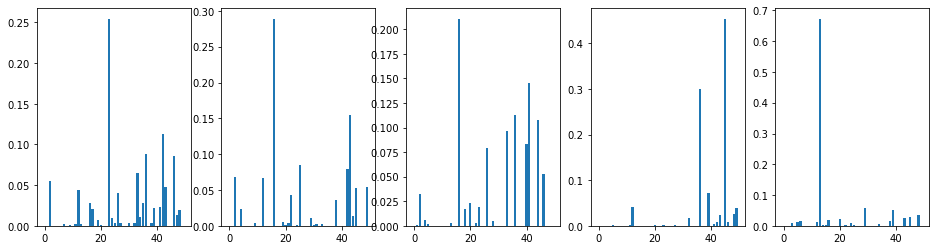

In [105]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(16,4))
axs[0].bar(np.arange(50), new_matrix[123])
axs[1].bar(np.arange(50), new_matrix[234])
axs[2].bar(np.arange(50), new_matrix[127])
axs[3].bar(np.arange(50), new_matrix[503])
axs[4].bar(np.arange(50), new_matrix[4949])
plt.show()

We just visualize a few random documents, to see what distributions of various topics look like. Interesting, some do have quite a few topics, while others do not! 

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis

In [107]:
print(f"Size of document-factor matrix: {Theta.shape}")
print(f"Size of factor-word matrix: {Beta.T.shape}")

Size of document-factor matrix: (19995, 50)
Size of factor-word matrix: (50, 79738)


In [108]:
doc_lengths = [len(corpus) for idx, corpus in enumerate(cord_corpus) 
               if idx in np.argwhere(new_matrix.sum(axis=1) == 1).reshape(-1)]
vocab = list(dictionary.token2id.keys())
vocab_tf={}
for i in cord_corpus:
    for item,count in dict(i).items():
        if item in vocab_tf:
            vocab_tf[item] += count
        else:
            vocab_tf[item] = count
            
# convert dict to list            
i = 0
tf = []
for i in range(len(vocab)):
    tf.append(vocab_tf[i])            

In [109]:
data = {'topic_term_dists': Beta.T, 
        'doc_topic_dists': new_matrix,
        'doc_lengths': doc_lengths,
        'vocab': vocab,
        'term_frequency': tf,}

In [110]:
nmf_vis_data = pyLDAvis.prepare(**data, mds="PCoA")

In [111]:
pyLDAvis.display(nmf_vis_data)

#### Cluster by Most Significant Factor 

In [119]:
import umap

In [115]:
reducer = umap.UMAP()

In [116]:
embedding = reducer.fit_transform(Beta)

<AxesSubplot:>

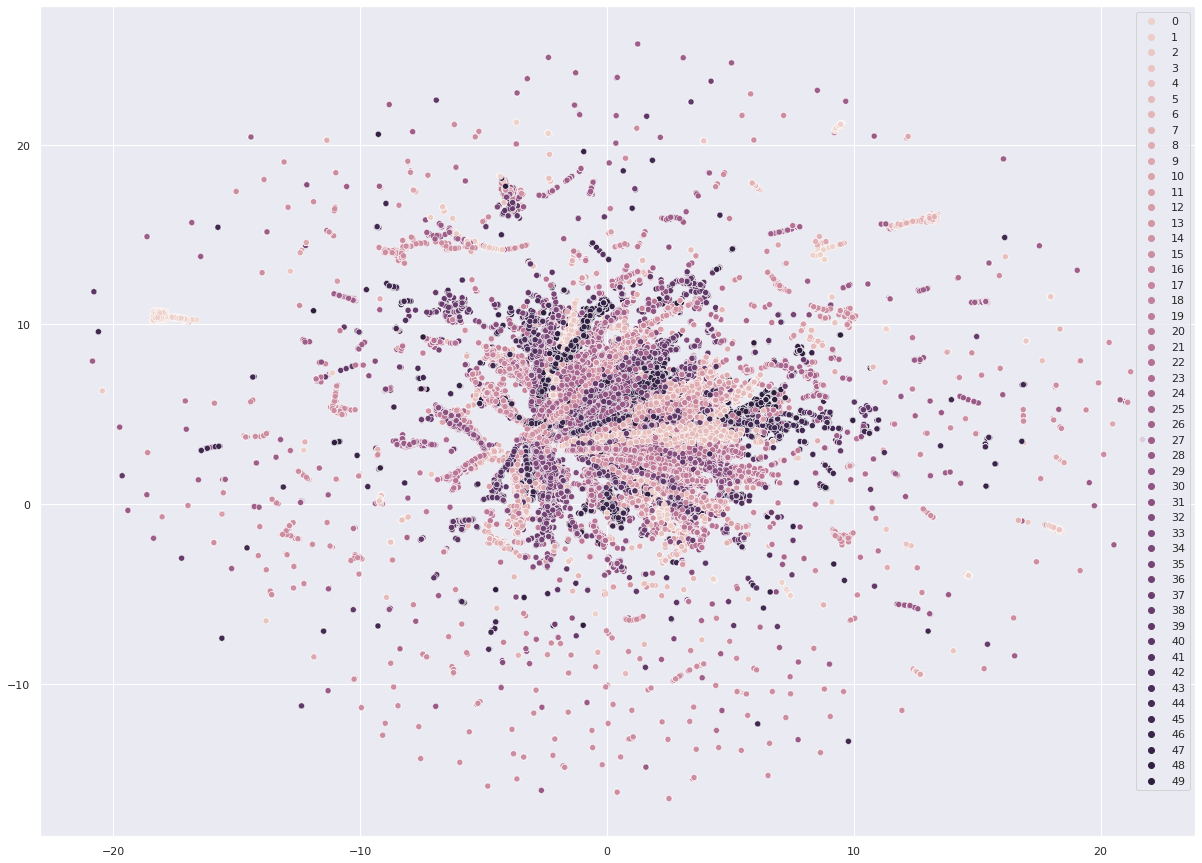

In [117]:
sns.set(rc={'figure.figsize':(20.7,15.27)})
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], 
                hue=list(np.argmax(Beta, axis=1)), 
                legend="full")

### Hierarchical Poisson Factorization (HPF) 

In [12]:
from hpfrec import HPF
import pandas as pd
import numpy as np
import scipy.sparse
import seaborn as sns

#### Fit HPC

In [13]:
hpf = HPF(
    k=50,
#     a=0.3, a_prime=0.3, b_prime=1.0,
#     c=0.3, c_prime=0.3, d_prime=1.0, ncores=-1,
#     stop_crit='train-llk', check_every=10, stop_thr=1e-3,
#     users_per_batch=None, items_per_batch=None, step_size=lambda x: 1/np.sqrt(x+2),
    maxiter=150, 
#     use_float=True, 
    reindex=False,
    #verbose=True, random_seed=None, allow_inconsistent_math=False, 
#     full_llk=True,
#     alloc_full_phi=False, keep_data=True, save_folder=None,
#     produce_dicts=True, keep_all_objs=True, sum_exp_trick=False
)

We'll first need to convert our corpus into a form that HPF accepts. We choose the scipy.sparse coo matrix format, rather than a large pandas DataFrame. 

In [14]:
cord_csc = gensim.matutils.corpus2csc(cord_corpus)

In [15]:
cord_coo = cord_csc.tocoo().transpose()

In [16]:
hpf.fit(cord_coo)

**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 20000
Number of items: 79738
Latent factors to use: 50

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...
Iteration 10 | train llk: -8294749 | train rmse: 1.8974
Iteration 20 | train llk: -7740137 | train rmse: 1.8414
Iteration 30 | train llk: -7518329 | train rmse: 1.8216
Iteration 40 | train llk: -7426463 | train rmse: 1.8131
Iteration 50 | train llk: -7385055 | train rmse: 1.8091
Iteration 60 | train llk: -7362706 | train rmse: 1.8067
Iteration 70 | train llk: -7348543 | train rmse: 1.8050
Iteration 80 | train llk: -7337901 | train rmse: 1.8036
Iteration 90 | train llk: -7330896 | train rmse: 1.8025


Optimization finished
Final log-likelihood: -7330896
Final RMSE: 1.8025
Minutes taken (optimization part): 14.6



#### Generate Random Document Text

Output the top 100 terms for two random patients to see what it looks like. 

In [17]:
u1 = 9113
u2 = 1593
text1 = hpf.topN(user=u1, n=100, exclude_seen=True)
text2 = hpf.topN(user=u2, n=100, exclude_seen=True)

In [18]:
sample = ""
for idx in text1:
    sample += dictionary[idx] + " "

print(sample)

print("\n")
sample = ""
for idx in text2:
    sample += dictionary[idx] + " "

print(sample)

virus patients viral respiratory infection influenza study viruses hiv infections disease cell human cells results lung research associated data analysis high risk vaccine protein clinical treatment based dengue methods specific new studies der acute expression hn time al activity different non group development levels resistance transplantation control vaccines use model potential material response immune pneumonia bacterial increased available gene et detection showed und health significantly supplementary children cases host th induced infected effects compared pathogens die samples sars syndrome diseases infectious including vaccination mice resistant biological positive significant effect blood role related mortality identified novel proteins water factors severe species 


age care children years associated data ci mortality patient pneumonia analysis higher background days conclusions significantly time rate outcome mean respiratory included high vs score non icu months year fai

Let's compare it to the original documents to see if they make some kind of sense. 

In [19]:
print(" ".join(cord_text[u1]))
print("\n")
print(" ".join(cord_text[u2]))


commentary


procalcitonin guidance reduction antibiotic use patients hospitalized severe acute exacerbations asthma randomized controlled study month follow introduction patients severe acute exacerbations asthma receive inappropriate antibiotic treatment aimed determine serum procalcitonin pct levels effectively safely reduce antibiotic exposure patients experiencing exacerbations asthma methods randomized controlled trial total patients requiring hospitalization severe acute exacerbations asthma screened eligibility participate completed month follow visit patients randomized pct guided pct group standard control group antimicrobial therapy control group patients received antibiotics according attending physician’s discretion pct group patients received antibiotics according algorithm based serum pct levels primary end point antibiotic exposure secondary end points clinical recovery length hospital stay clinical laboratory parameters spirometry number asthma exacerbations emergency 

#### Row Normalize $\theta$ vectors

Normalizing our vectors gives us probabilities for each factor. 

In [20]:
row_sums = hpf.Theta.sum(axis=1)
new_matrix = hpf.Theta / row_sums[:, np.newaxis]

#### Visualize

In [21]:
import matplotlib.pyplot as plt

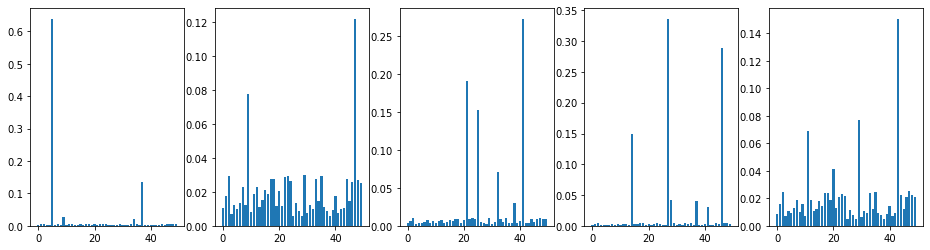

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(16,4))
axs[0].bar(np.arange(50), new_matrix[123])
axs[1].bar(np.arange(50), new_matrix[234])
axs[2].bar(np.arange(50), new_matrix[127])
axs[3].bar(np.arange(50), new_matrix[503])
axs[4].bar(np.arange(50), new_matrix[4949])
plt.show()

We just visualize a few random documents, to see what distributions of various topics look like. Interesting, some do have quite a few topics, while others do not! 

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis

In [24]:
print(f"Size of document-factor matrix: {hpf.Theta.shape}")
print(f"Size of factor-word matrix: {hpf.Beta.T.shape}")

Size of document-factor matrix: (20000, 50)
Size of factor-word matrix: (50, 79738)


/gpfs/ysm/project/rtaylor/vs428/conda_envs/hpf_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
doc_lengths = [len(corpus) for corpus in cord_corpus]
vocab = list(dictionary.token2id.keys())
vocab_tf={}
for i in cord_corpus:
    for item,count in dict(i).items():
        if item in vocab_tf:
            vocab_tf[item] += count
        else:
            vocab_tf[item] = count
            
# convert dict to list            
i = 0
tf = []
for i in range(len(vocab)):
    tf.append(vocab_tf[i])            

/gpfs/ysm/project/rtaylor/vs428/conda_envs/hpf_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
data = {'topic_term_dists': hpf.Beta.T, 
        'doc_topic_dists': new_matrix,
        'doc_lengths': doc_lengths,
        'vocab': vocab,
        'term_frequency': tf,}

/gpfs/ysm/project/rtaylor/vs428/conda_envs/hpf_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
hpf_vis_data = pyLDAvis.prepare(**data, mds="PCoA")

In [68]:
pyLDAvis.display(hpf_vis_data)

#### Cluster by Most Significant Factor 

In [67]:
import umap

In [35]:
reducer = umap.UMAP()

In [36]:
embedding = reducer.fit_transform(hpf.Beta)

<AxesSubplot:>

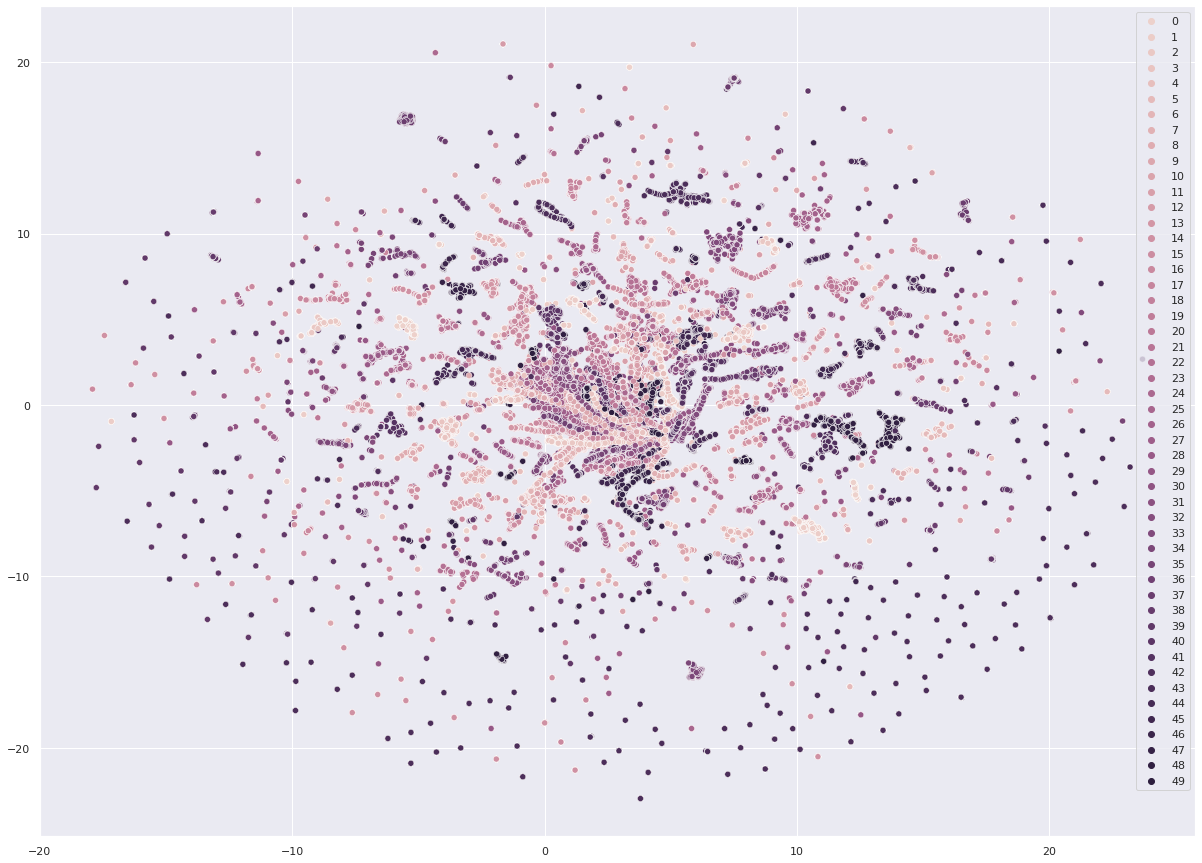

In [61]:
sns.set(rc={'figure.figsize':(20.7,15.27)})
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], 
                hue=list(np.argmax(hpf.Beta, axis=1)), 
                legend="full")

# References

(<a id="cit-jelodar2019latent" href="#call-jelodar2019latent">Jelodar, Wang <em>et al.</em>, 2019</a>) Jelodar Hamed, Wang Yongli, Yuan Chi <em>et al.</em>, ``_Latent Dirichlet Allocation (LDA) and Topic modeling: models, applications, a survey_'', Multimedia Tools and Applications, vol. 78, number 11, pp. 15169--15211,  2019.

(<a id="cit-blei2003latent" href="#call-blei2003latent">Blei, Ng <em>et al.</em>, 2003</a>) Blei David M, Ng Andrew Y and Jordan Michael I, ``_Latent dirichlet allocation_'', Journal of machine Learning research, vol. 3, number Jan, pp. 993--1022,  2003.

(<a id="cit-lee1999learning" href="#call-lee1999learning">Lee and Seung, 1999</a>) Lee Daniel D and Seung H Sebastian, ``_Learning the parts of objects by non-negative matrix factorization_'', Nature, vol. 401, number 6755, pp. 788--791,  1999.

(<a id="cit-gopalan2015scalable" href="#call-gopalan2015scalable">Gopalan, Hofman <em>et al.</em>, 2015</a>) P. Gopalan, J.M. Hofman and D.M. Blei, ``_Scalable Recommendation with Hierarchical Poisson Factorization._'', UAI,  2015.

(<a id="cit-doanvo2020machine" href="#call-doanvo2020machine">Doanvo, Qian <em>et al.</em>, 2020</a>) Doanvo Anhvinh L, Qian Xiaolu, Ramjee Divya <em>et al.</em>, ``_Machine Learning Maps Research Needs in COVID-19 Literature_'', bioRxiv, vol. , number , pp. ,  2020.

(<a id="cit-sievert2014ldavis" href="#call-sievert2014ldavis">Sievert and Shirley, 2014</a>) C. Sievert and K. Shirley, ``_LDAvis: A method for visualizing and interpreting topics_'', Proceedings of the workshop on interactive language learning, visualization, and interfaces,  2014.

